In [1]:
import numpy as np
import netgen.geom2d as geom2d
from ngsolve import *
from ngsolve.webgui import Draw
# visualization stuff
from ngsolve.internal import *
from interpolations import InterpolateLevelSetToElems # function which interpolates a levelset function

#Constants and geometry

myMAXH = 0.025
EPS = myMAXH * 1e-6
epsi = 1e-3

geo = geom2d.SplineGeometry()

pnums = [geo.AddPoint (x,y,maxh=0.1) for x,y in [(0,0), (0.1,0),(1.9,0),(2,0), (2,1.2), (0,1.2)] ]
for p1,p2,bc in [(0,1,"roller_left"),(1,2,"bot") ,(2,3,"roller_right"),(3,4,"right"), (4,5,"top"), (5,0,"left")]:
        geo.Append(["line", pnums[p1], pnums[p2]], bc=bc)
mesh = Mesh(geo.GenerateMesh(maxh=myMAXH))
E, nu = 1, 0.3 
ell = 30
mu  = E / 2 / (1+nu)
lam_star = (E*nu)/((1+nu)*(1-2*nu)) 
lam = (2*mu*lam_star)/(lam_star+2*mu)

def Stress(strain):
    return 2*mu*strain + lam*Trace(strain)*Id(2)
def Eps ( u ) :
    return 1/2 * ( Grad(u)+Grad(u).trans )
#Spaces
fes = VectorH1(mesh, order=1,dirichlet="roller_left|roller_right",dim=1)
fes_grad = H1(mesh, order=1,dim=4)
fes_level = H1(mesh, order=1,dim=1)
pwc = L2(mesh)   #piecewise constant space

#to get load points
load_point_index = 0
L_test = LinearForm(fes)

L_test.Assemble()   

for v in mesh.vertices:
    if v.point[1] == 0 and abs(v.point[0]-1)< epsi:
        load_point_index = int(v.nr+(len(L_test.vec)/2)) 
        #load_point_index = v.nr
        print("Load Point ", v.point, v)
        print("Load Point Index (for y-component of the force):", load_point_index)

#Constants for alpha 
alpha_in = 1
alpha_out = epsi #"Soft Material" Approximation 

#Level Set Function 
psi = GridFunction(fes_level)
psinew = GridFunction(fes_level)
psi.Set(-1)

#Piecewise constant coefficient function alpha
alpha = GridFunction(pwc)
alpha.Set(alpha_in)

u,v = fes.TnT()
gfu = GridFunction(fes) #vector H1  

TD_node = GridFunction(fes_level) #Scalar H1
g_k = GridFunction(fes_level)

TD_pwc = GridFunction(pwc)  #Scalar PWC
TDPosNeg_pwc = GridFunction(pwc) 
TDNegPos_pwc = GridFunction(pwc) 
cutRatio = GridFunction(pwc) 
#Formes and solver

B = BilinearForm(alpha*InnerProduct(Stress(Eps((u))), Eps((v))).Compile()*dx)   
L = LinearForm(fes)



def SolvePDE():
    InterpolateLevelSetToElems(psi, alpha_in, alpha_out, alpha, mesh, EPS) 

    B.Assemble()
    L.Assemble()
    L.vec[load_point_index]=-1 
    inv_state = B.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky")
  
    # solve state equation
    gfu.vec.data = inv_state*L.vec
SolvePDE()
Draw(gfu)
print(fes_level.ndof)
mesh.nv,mesh.ne
#(4586, 8914)

Load Point  (0.9999999999999999, 0.0) V44
Load Point Index (for y-component of the force): 4630


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

4586


(4586, 8914)

In [2]:
#MAIN LOOP
N = fes_level.ndof

costs = []
iterations = [] 
thetas = []
active_dofs = []

#psi.Set(-1)
psi.Set( (x-1)**2+(y-0.5)**2-0.25**2)

InterpolateLevelSetToElems(psi, alpha_in, alpha_out, alpha, mesh, EPS)
psinew.vec.data= psi.vec

SolvePDE()

# TD Constants:
alpha_in = 1 
alpha_out = epsi
r_in = alpha_out/alpha_in
r_out = alpha_in/alpha_out
kappa_td=(lam+3*mu)/(lam+mu)

const_NegPos =  alpha_in* ( (r_in-1)/(kappa_td*r_in+1) )*( (kappa_td+1)  / 2 )    #multiplied by -ve 1 

const_PosNeg = -alpha_out*( (r_out-1)/(kappa_td*r_out+1) )*((kappa_td+1) / 2 )

const_in_NegPos = ( (r_in-1)*(kappa_td-2)/(kappa_td+2*r_in-1) )

const_in_PosNeg= ( (r_out-1)*(kappa_td-2)/(kappa_td+2*r_out-1) )

kappa=0.5
kappa_max = 1
iter_max = 125

vol = GridFunction(pwc)
InterpolateLevelSetToElems(psi, 1, 0, vol, mesh, EPS)
compliance_cf= InnerProduct ( alpha*Stress(Eps(gfu)) , Eps(gfu)   )
j = Integrate(compliance_cf, mesh) + ell*Integrate(vol,mesh)
print("Cost before loop = " ,j)
for i in range(4):
    costs.append(j)

scene_u = Draw(gfu) ##DRAW
scene_psi = Draw(IfPos(psi,1,-1),mesh)
theta_k = 130
theta_tolerance = 2


with TaskManager():

    for k in range(iter_max):


        print("================ iteration ", k, "===================")
        psi.vec.data=psinew.vec 
        scene_psi.Redraw()
        InterpolateLevelSetToElems(psi, alpha_in, alpha_out, alpha, mesh, EPS)
        InterpolateLevelSetToElems(psi, 1, 0, vol, mesh, EPS)
        InterpolateLevelSetToElems(psi, 1, 0, cutRatio, mesh, EPS) # compute the cut ratio of the interface elements

        SolvePDE()
        scene_u.Redraw()

        compliance_cf= InnerProduct ( alpha*Stress(Eps(gfu)) , Eps(gfu)   )
        J_current = Integrate(compliance_cf, mesh) + ell*Integrate(vol,mesh)
        costs.append(J_current)
        last_five_costs = costs[-5:]
        max_last_five = max(last_five_costs) #  for the line search
        print("cost in beginning of iteration", k, ": Cost = ", J_current)
        print("Maximum cost in last 5 iterations = ",max_last_five) 

        #Topological derivative 
 
        trm1= 2*InnerProduct(Stress(Eps(gfu)), Eps(gfu))    
        trm2=Trace(Stress(Eps(gfu)))*Trace(Eps(gfu))
        TDPosNeg_pwc.Set( const_PosNeg * (trm1+const_in_PosNeg*trm2)  + ell )                        
        TDNegPos_pwc.Set( const_NegPos * (trm1+const_in_NegPos*trm2)  + ell )
        for j in range(len(TD_pwc.vec)):
            TD_pwc.vec[j] = cutRatio.vec[j] * TDNegPos_pwc.vec[j] + (1-cutRatio.vec[j])*TDPosNeg_pwc.vec[j]

        TD_node.Set(TD_pwc)


        normTD = sqrt(Integrate(TD_node**2*dx, mesh)) # L2 norm of TD_node
        normPsi = sqrt(Integrate(psi**2*dx, mesh)) # L2 norm of psi
       
        const_gk = Integrate(psi*TD_node,mesh)/(normPsi**2)
        g_k.Set( -1*(TD_node-const_gk*psi)   )  
        
        TD_node.vec.data = (1/(normTD)) * TD_node.vec # normalised TD_node
        psi.vec.data = 1/normPsi * psi.vec  # normalised psi
        ##########################
        arg_arc = Integrate(psi*TD_node,mesh)/(normTD*normPsi)
        theta_k = np.arccos(arg_arc)*180/np.pi
        print("Theta_k =",theta_k,"  degrees")
        thetas.append(theta_k)
        if theta_k < theta_tolerance:
            break

        indices = []
        for i in range(N):
                if (psi.vec[i] < 0) and (TD_node.vec[i] > 0):#In Omega  -DJ>0 mm DJ < 0 , NOT optimal
                    indices.append(i)
                elif(psi.vec[i] > 0) and (TD_node.vec[i] < 0): #OUT Omega
                    indices.append(i)
        active_dofs.append(len(indices))
        iterations.append(k)
        print("ACTIVE DOFS",len(indices) )
        if (len(indices) < int(0.005*N)) and (k > 4) :
            print("99.5% of elements satisfy optimality conditions, non optimal elements are",len(indices) ," out of ",N )
            break

        for j in range(10):

            # update the level set function
            psinew.vec.data = (1-kappa)*psi.vec + kappa*TD_node.vec
            #psinew.vec.data = psi.vec - kappa *g_k.vec
            # update beta and f_rhs
            InterpolateLevelSetToElems(psinew, 1, 0, vol, mesh, EPS)
            InterpolateLevelSetToElems(psinew, alpha_in, alpha_out, alpha, mesh, EPS)

            # solve PDE without adjoint
            SolvePDE()

            Redraw(blocking=True)
            compliance_cf= InnerProduct ( alpha*Stress(Eps(gfu)) , Eps(gfu)   )
            J_new = Integrate(compliance_cf, mesh) + ell*Integrate(vol,mesh)

            if J_new > max_last_five:
                print("--------------------")
                print("-----line search ---")
                print("--------------------")
                kappa = kappa*0.6
                kappa = max(0.001,kappa) 
                print("kappa", kappa)
            else:
                kappa = min(kappa_max, kappa*1.2)
                print("Step accepted , size increased from " , kappa/1.2 ,"to ",kappa)                
                break


        print("end of iter " + str(k))


Cost before loop =  4412.895580089694


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

================ iteration  0 ===================
cost in beginning of iteration 0 : Cost =  4412.89558011514
Maximum cost in last 5 iterations =  4412.89558011514
Theta_k = 90.00014813087937   degrees
ACTIVE DOFS 4333
--------------------
-----line search ---
--------------------
kappa 0.3
--------------------
-----line search ---
--------------------
kappa 0.18
--------------------
-----line search ---
--------------------
kappa 0.108
--------------------
-----line search ---
--------------------
kappa 0.0648
--------------------
-----line search ---
--------------------
kappa 0.03888
--------------------
-----line search ---
--------------------
kappa 0.023327999999999998
--------------------
-----line search ---
--------------------
kappa 0.013996799999999998
--------------------
-----line search ---
--------------------
kappa 0.008398079999999999
--------------------
-----line search ---
--------------------
kappa 0.005038847999999999
--------------------
-----line search ---
----

In [3]:
 Draw(IfPos(psi,1,-1),mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

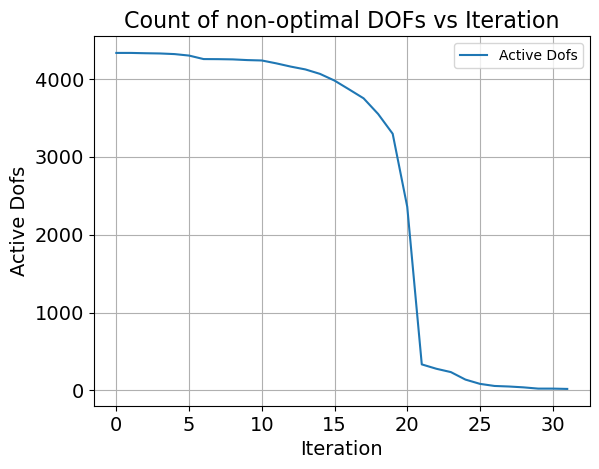

In [4]:
import matplotlib.pyplot as plt# Figure 1: Norm vs Iteration
plt.figure()
plt.plot(iterations, active_dofs, label='Active Dofs')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Active Dofs', fontsize=14)
plt.title('Count of non-optimal DOFs vs Iteration', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.grid(True)
plt.savefig("active_dofs_bridge_single_conv_REF_circ.png")
#plt.show()


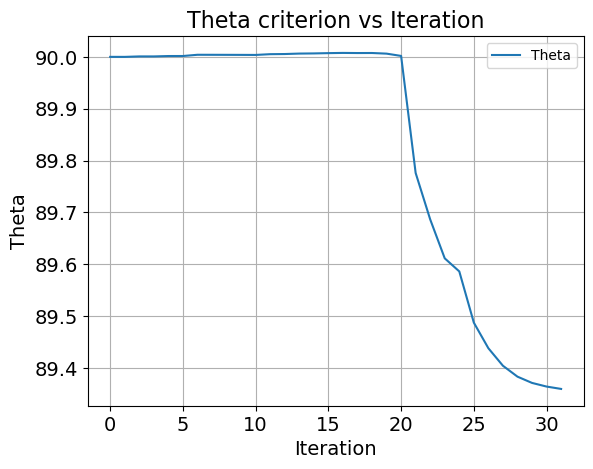

In [5]:
import matplotlib.pyplot as plt# Figure 1: Norm vs Iteration
plt.plot(iterations, thetas, label='Theta')
plt.xlabel('Iteration',fontsize=14)
plt.ylabel('Theta',fontsize=14)
plt.title('Theta criterion vs Iteration',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.grid(True)
plt.savefig("theta_bridge_single_conv_REF_circ.png")
plt.show()




